# <font style="color:blue">Mask / No Mask Detector - YOLO v3 - Linux</font>
- In this notebook we will train a custom object detector using YOLO v3
- We assume that you will link the drive manually
- We will take care of the rest when you pass section 1 link manually.
- After that everything goes fluidly.

First some imports

In [0]:
import random
import os
import subprocess
import sys
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from google.colab import drive
from datetime import datetime

%matplotlib inline



### <font color="blue">0.  Verification of the GPU </font>
Just seeing which GPU on the cloud.

In [0]:
#Test to see if we are using the GPU
if 'GPU:0' in tf.test.gpu_device_name():
  print("We are using the GPU!")
else:
  print("No GPU Allocated")

We are using the GPU!


In [0]:
#Which type of GPU?
!nvidia-smi

Fri Jun 12 00:56:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    30W / 250W |    353MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### <font color="blue">1.  Load Google Drive</font>
We will load our google drive space to simplify the process

In [0]:
drive.mount('/content/drive')
!rm -rf /content/drive/My\ Drive/YOLO # clean install if exists

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### <font color="blue">2.  Change to the Drive space</font>
Now we will be inside our drive to allocate the files and also create a folder specifically to yolov3 [this project].

In [0]:
%cd /content/drive/My\ Drive
%mkdir YOLO

/content/drive/My Drive


### <font color="blue">3.  Download Alexey AB YOLO repository to our google drive *yolov3* folder</font>
We now will download the well maintained repository of a YOLO expert, because Joseph Redmon will not continue working on YOLO.

In [0]:
%cd /content/drive/My\ Drive/YOLO
!rm -rf darknet # clean folder if exists, sometimes when reconnecting gives error about permissions
!git clone https://github.com/AlexeyAB/darknet.git

/content/drive/My Drive/YOLO
Cloning into 'darknet'...
remote: Enumerating objects: 13658, done.
remote: Total 13658 (delta 0), reused 0 (delta 0), pack-reused 13658
Receiving objects: 100% (13658/13658), 12.25 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (9319/9319), done.
Checking out files: 100% (2004/2004), done.


### <font color="blue">4.  Compile Darknet</font>
Modify some strings on the makefile to compile darknet.

In [0]:
%cd /content/drive/My\ Drive/YOLO/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    
print("[INFO] - Building Darknet, this will take a few minutes. Get a coffee!")

!make &> build_log.txt

print("[INFO] - Build Finished!")


/content/drive/My Drive/YOLO/darknet
[INFO] - Building Darknet, this will take a few minutes. Get a coffee!
[INFO] - Build Finished!


### <font color="blue">5.  Download the *Mask / No Mask Dataset*</font>
Download the curated dataset of face mask and not facemask to our dataset folder, but first lets create a dataset folder.

Usually i like to be very organized.

In [0]:
%cd /content/drive/My\ Drive/YOLO
%mkdir dataset

/content/drive/My Drive/YOLO


In [0]:
%cd /content/drive/My\ Drive/YOLO/dataset
!wget https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip
!unzip kaggle_and_no-mask_dataset.zip &> /dev/null
!rm -rf kaggle_and_no-mask_dataset.zip
!rm -rf .ipynb_checkpoints/

/content/drive/My Drive/YOLO/dataset
--2020-06-12 01:00:39--  https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip [following]
--2020-06-12 01:00:39--  https://www.dropbox.com/s/raw/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc876bbae2ef4af187b7e3b293d3.dl.dropboxusercontent.com/cd/0/inline/A5fQ9jNpj_L2FibWypbl4xcvlM6HmfHuumAdEYiXrDKndxrJbNThZ_ZVXRx2oesTxwWFJvZFW6ep46tFEShzoSRT6hWXg-6izbR_BtbUDmwY8aphABS2FJsm96Z2iA3gCNw/file# [following]
--2020-06-12 01:00:39--  https://uc876bbae2ef4af187b7e3b293d3.dl.dropboxusercontent.com/cd/0/inline/A5fQ9jNpj_L2FibWypbl4xc

### <font color="blue">6.  Prepare the Train and Test Files</font>
This code provided creates two files, one for the training images and other for the test images.

The dataset is divided in:
- 80% training set 
- 20% test set

In [0]:
%cd /content/drive/My Drive/YOLO

image_dir = "./dataset"
f_val = open("DS_test.txt", 'w')
f_train = open("DS_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

/content/drive/My Drive/YOLO


### <font color="blue">7.  Prepare and Upload the configuration files</font>

For train and use yolo we need to prepare the neccesary files, finally we will upload to our yolov3 folder.

#### <font color="blue">7.1. Data Setup</font>
In the file **`yolov3-mask_nomask-setup.data`**(uploaded to github and included here), we provided the correct specification of our paths.

Below is the content of this file:
```
classes = 2
train  = DS_train.txt
valid  = DS_test.txt
names = FacialMaskDetector/yolov3/config/yolov3.names
backup = FacialMaskDetector/yolov3/backup/
```

#### <font color="blue">7.2. Training Config File</font>
We also need to provide the  **`yolov3-mask_nomask-train.cfg`**. Based on the default file of darknet folder over the VOC dataset, yolov3-voc.cfg.

#### <font color="blue">7.2.1 Batch hyper-parameter in YOLOv3</font>
We maintained the batch size and the subdivision batch as my the defaults of the file. A batch of 16 with subdivisions of 8.

For the test configuration file we will set these params to 1 because we will feed an image.
```
[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=16
subdivisions=8
```
#### <font color="blue">7.2.2 Subdivisions configuration parameter in YOLOv3</font>
For feeding the GPU correcly we slow the training, this action will ensure our machine will be able to train the detector but you could play with this parameter.

In testing mode this will be equal to 1.

### <font color="blue">7.2.3 Width, Height, Channels</font>
A higher resolution the detection will be better but you will sacrifice the time of training.
```
width=512
height=512
channels=3
```
### <font color="blue">7.2.4 Momentum and Decay</font>
These hyperparameters we will maintain as is.
```
momentum=0.9
decay=0.0005
```

### <font color="blue">7.2.5 Learning Rate, Steps, Scales, Burn In (warm-up)</font>
Again, we will be maintaining these hyperparamters as default.  The learning rate will be changed over the 800th iteration.

```
learning_rate=0.001
policy=steps
steps=7000,8000,9000
scales=.1,.1,.1
burn_in=1000
```


### <font color="blue">7.2.6 Data augmentation</font>
For various lighting conditions and different color ranges (over other color spaces).  Sometimes its good to change the angle because a few objects could be rotated.  A facemask in this case we will maintain at 0 degrees but could be augmented to 3° or something low because we are detecting people.
```
angle=0
saturation = 1.5
exposure = 1.5
hue=.1
```

#### <font color="blue">7.2.7 Number of iterations</font>
Process 2000*n_classes iterations run as recommended.  But we will keep in 10000 to see the performance.
```
max_batches=10000
```

#### <font color="blue">7.2.8 Change filters parameter in conv layers [Important for multiple objects]</font>
Fini in the file the conv. layer before the yolo layer with the equation:

**`filters=( classes + 5 ) * 3`**

Our yolo classes are 2, so filters = 21.

### <font color="blue">7.3. yolov3.names file </font>
Specify the Mask (Class 0), No-Mask (Class 1) class labels.

### <font color="blue">8. Cloning the configuration Repository</font>
This repository is prepared with the desired configuration for yolov3 and yolov4.

In this case we will be using yolo v3.  The structure of the folder (for yolo v3 only for simplicity) is as follows:

```
/FacialMaskDetector
├── test
│   ├── test-image1.jpg
│   ├── test-image2.jpg
│   ├── test-image3.jpg
│   ├── test-image4.jpg
│   ├── test-video1.jpg
│   ├── test-video2.jpg
├── yolov3
│       ├── backup
│       │   ├── README.md
│       ├── config
│           ├── yolov3-mask_nomask-setup.data
│           ├── yolov3-mask_nomask-test.cfg
│           ├── yolov3-mask_nomask-train.cfg
│           ├── yolov3.names
│       ├── weights
│           ├── README.md
├── README.md
```

This will ease for us the way of training and inference.

In [0]:
%cd /content/drive/My Drive/YOLO
!git clone https://github.com/issaiass/FacialMaskDetector.git

/content/drive/My Drive/YOLO
Cloning into 'FacialMaskDetector'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 101 (delta 11), reused 29 (delta 8), pack-reused 67
Receiving objects: 100% (101/101), 61.29 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Checking out files: 100% (23/23), done.


### <font color="blue">9. Cloning the Weights</font>
We will be doing fine-tuning, so we need to download the actual pre-trained weights.

In [0]:
%cd /content/drive/My\ Drive/YOLO/FacialMaskDetector/yolov3/weights

# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

/content/drive/My Drive/YOLO/FacialMaskDetector/yolov3/weights
--2020-06-12 01:01:33--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2020-06-12 01:01:33--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6498fc3d45013c1aec7f5456e5.dl.dropboxusercontent.com/cd/0/get/A5c55-qUyUiptzTw9q_NgibvcB3G5YV--Ayl2_HUw_5ojBAcBhNU9_FvHaMG23YG1fVU2AVFwyQwGkqWagr4pG7AjPUzbm8JT-8FjQQwkgZNRMLqNfDufJExo_Z59J4npQM/file?dl=1# [following]
--2020-06-12 01:01:34--  https://uc6498fc3d45013c1aec7f5456e5.dl.dropboxusercontent.com/cd/0/get/A5c55-qUyUiptzTw9q_NgibvcB3G5YV--A

### <font color="blue">10. Copy Labels Folder </font>

First we did a first step that is to copy the data folder of darknet to the root, because inside are the labels to graph the letters and numbers.  If this step is omited you will see a black box and no inference name.

In [0]:
%cd /content/drive/My\ Drive/YOLO
!mkdir data
!cp -R darknet/data/* ./data

/content/drive/My Drive/YOLO


### <font color="blue">11. Review Hyperparameters</font>

If you want to change some hyperparameters this is a good way to do it.

Finally, always check your changes.

In [0]:
# this is for using as arguments of the terminal
yolo_setup        = 'FacialMaskDetector\/yolov3\/config\/yolov3-mask_nomask-setup.data'
yolo_train        = 'FacialMaskDetector\/yolov3\/config\/yolov3-mask_nomask-train.cfg'
yolo_test         = 'FacialMaskDetector\/yolov3\/config\/yolov3-mask_nomask-test.cfg'
yolo_weights      = 'FacialMaskDetector\/yolov3\/weights\/darknet53.conv.74'
yolo_best_weights = 'FacialMaskDetector\/yolov3\/backup\/yolov3-mask_nomask-train_best.weights'
yolo_test_path    = 'FacialMaskDetector\/test'

In [0]:
%cd /content/drive/My\ Drive/YOLO

#An example for changing specific lines in a file
#!sed -i 's/batch=32/batch=16/' $yolo_train
#!sed -i 's/subdivisions=16/subdivisions=8/' $yolo_train
#!sed -i 's/width=416/width=512/' $yolo_train
#!sed -i 's/height=416/height=512/' $yolo_train
#!sed -i 's/learning_rate=0.001/learning_rate=0.001/' $yolo_train
#!sed -i 's/burn_in=600/burn_in=1000/' $yolo_train
#!sed -i 's/max_batches=6000/max_batches=10000/' $yolo_train
#!sed -i 's/steps=4200,4800,5400/steps=7000,8000,9000/' $yolo_train
#!sed -i 's/scales=.1,.1,.1,.1/scales=.1,.1,.1/' $yolo_train

#Check if the configuration of hyperparameter is ok
!head -25 FacialMaskDetector/yolov3/config/yolov3-mask_nomask-train.cfg

/content/drive/My Drive/YOLO
/content/drive/My Drive/YOLO
# Based on cfg/yolov3-voc.cfg

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=16
subdivisions=8
width=512
height=512
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches=10000
policy=steps
steps=7000,8000,9000
scales=.1,.1,.1


### <font color="blue">12. Start Training </font>

We need to pass the training files for the darknet framework to start the process.

Remember!, we need to specify the complete paths of these files that we talked before:
1. setup file, 
1. config file, 
1. convolutional weights file 

There are a few flags like **`dont_show`** which wont display the graphs and **`map`** - for the mAP calculation over the DS_test.txt file (20% of our data).

In [0]:
%cd /content/drive/My\ Drive/YOLO
#!chmod 777 /content/drive/My\ Drive/YOLO/darknet/darknet
!./darknet/darknet detector train  $yolo_setup $yolo_train $yolo_weights -dont_show -map 2> train_log.txt

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 total_bbox = 865810, rewritten_bbox = 0.013513 % 
 total_bbox = 865813, rewritten_bbox = 0.013513 % 
 total_bbox = 865826, rewritten_bbox = 0.013513 % 
 total_bbox = 865827, rewritten_bbox = 0.013513 % 
 total_bbox = 865828, rewritten_bbox = 0.013513 % 
 total_bbox = 865838, rewritten_bbox = 0.013513 % 
 total_bbox = 865870, rewritten_bbox = 0.013512 % 

 (next mAP calculation at 9670 iterations) 
 Last accuracy mAP@0.5 = 87.77 %, best = 88.44 % 
 9635: 0.801154, 0.834288 avg loss, 0.000001 rate, 1.431255 seconds, 154160 images, 0.234654 hours left
Loaded: 0.000060 seconds
 total_bbox = 865883, rewritten_bbox = 0.013512 % 
 total_bbox = 865890, rewritten_bbox = 0.013512 % 
 total_bbox = 865893, rewritten_bbox = 0.013512 % 
 total_bbox = 865944, rewritten_bbox = 0.013511 % 
 total_bbox = 865950, rewritten_bbox = 0.013511 % 
 total_bbox = 865952, rewritten_bbox = 0.013511 % 
 total_bbox = 865961, rewritten_bbox = 0.01351

Our results:

- Last accuracy mAP@0.5 = 87.71 %, best = 88.44 % 
 10000: 0.678672, 0.730213 avg loss, 0.000001 rate, 3.044799 seconds, 160000 images, 0.056984 hours left

- detections_count = 3096, unique_truth_count = 1517  
- class_id = 0, name = Mask, ap = 92.32%   	 (TP = 462, FP = 42) 
- class_id = 1, name = No-Mask, ap = 82.30%   	 (TP = 747, FP = 93)

And the training time was about 8 to 10 hours.

### <font color="blue">13. Displaying code</font>

This code will display in the same canvas both images, the original one and the yolo predictions marked on it.

In [0]:
def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")

    file_name = imagePath.split('/')
    file_name_parts = file_name[2].split('.')
    name_only = file_name_parts[0]
    now = datetime.now() # current date and time
    build = now.strftime("%m-%d-%Y_%H_%M_%S")
    file_save_path = os.path.join(file_name[0], 'result', 'yolov3')
    save_name = os.path.join(file_save_path, name_only + '-yolov3--' + build +'.png')
    print(f"Saved at: {save_name}")
    plt.savefig(save_name)

    plt.show()

### <font color="blue">14. Making Inferences </font>

This code will display in the same canvas both images, the original one and the yolo predictions marked on it.

This code will display in the same canvas both images, the original one and the yolo predictions marked on it.

Finally are the inferences of images and pre-recorded video.

The pre-recorded video could be downloaded over the root folder, in this case, our YOLO folder (created on Google Drive).

Before start making inferencs, let's get the files paths.

In [0]:
%cd /content/drive/My\ Drive/YOLO
yolo_test_path = os.path.join('FacialMaskDetector', 'test')
test_files = [os.path.join(yolo_test_path, v) for v in os.listdir(yolo_test_path)]

/content/drive/My Drive/YOLO


#### <font color="blue">14.1 Scenario 1</font>

Testing only with one man and with facemask.

/content/drive/My Drive/YOLO
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 122 K-images (1 Kilo-batches_64) 
FacialMaskDetector/test/test-image1.jpg: Predicted in 33.530000 milli-seconds.
Mask: 100%
Saved at: FacialMaskDetector/result/yolov3/test-image1-yolov3--06-12-2020_07_27_29.png


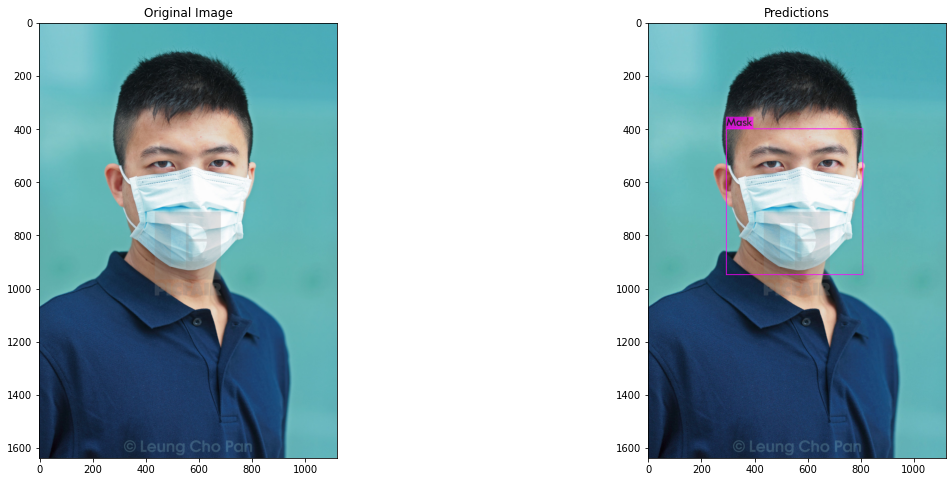

In [0]:
# Uncomment the line belowif you prebuilt darknet and want to change the permissions of the file
#!chmod 777 /content/drive/My\ Drive/YOLO/darknet/darknet
%cd /content/drive/My\ Drive/YOLO
!./darknet/darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-image1.jpg -thresh .6 2> /dev/null
display_output(test_files[0])

#### <font color="blue">14.2 Scenario 2</font>

Testing with different angles of people wearing mask and other not wearing.

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 122 K-images (1 Kilo-batches_64) 
FacialMaskDetector/test/test-image2.jpg: Predicted in 33.228000 milli-seconds.
Mask: 100%
Mask: 99%
Mask: 99%
No-Mask: 100%
Mask: 99%
Saved at: FacialMaskDetector/result/yolov3/test-image2-yolov3--06-12-2020_07_27_42.png


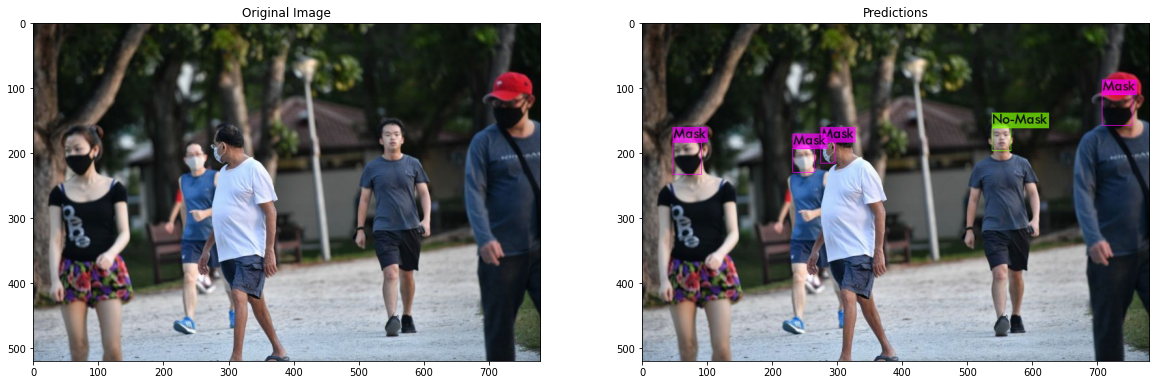

In [0]:
!./darknet/darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-image2.jpg -thresh .6 2> /dev/null
display_output(test_files[1])

#### <font color="blue">14.3 Scenario 3</font>

Testing with a crowd with and without facemask and different scales and variations

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 122 K-images (1 Kilo-batches_64) 
FacialMaskDetector/test/test-image3.jpg: Predicted in 33.287000 milli-seconds.
Mask: 99%
Mask: 99%
Mask: 100%
No-Mask: 99%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 99%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 99%
Mask: 99%
Mask: 100%
Saved at: FacialMaskDetector/result/yolov3/test-image3-yolov3--06-12-2020_07_27_56.png


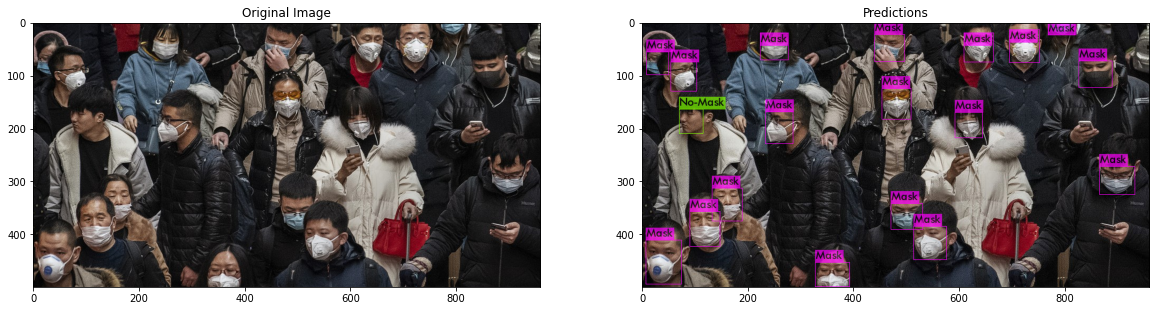

In [0]:
!./darknet/darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-image3.jpg -thresh .6 2> /dev/null
display_output(test_files[2])

#### <font color="blue">14.4 Scenario 4</font>

Testing with several people walking trough the plaza.

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 122 K-images (1 Kilo-batches_64) 
FacialMaskDetector/test/test-image4.jpg: Predicted in 33.091000 milli-seconds.
No-Mask: 99%
No-Mask: 77%
Mask: 100%
Mask: 100%
No-Mask: 97%
Mask: 100%
No-Mask: 58%
Mask: 100%
Saved at: FacialMaskDetector/result/yolov3/test-image4-yolov3--06-12-2020_07_28_59.png


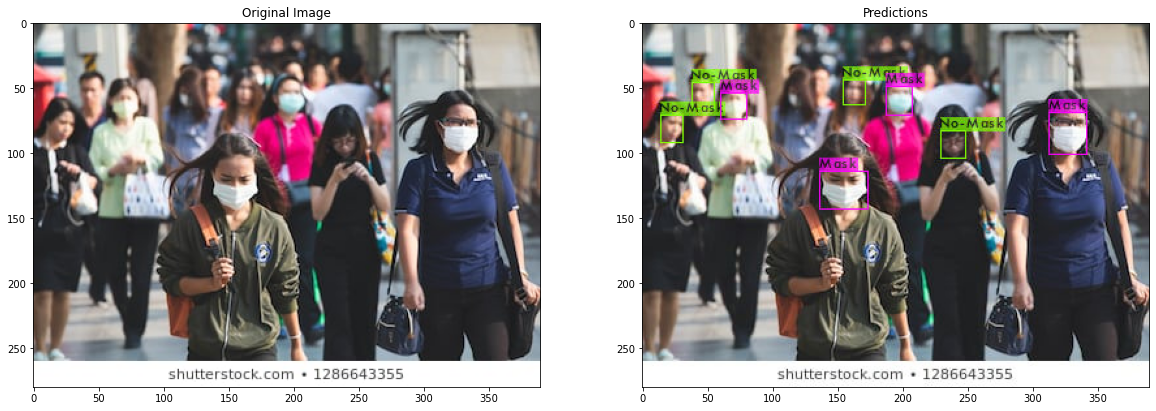

In [0]:
!./darknet/darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-image4.jpg -thresh .5 2> /dev/null
display_output(test_files[3])

#### <font color="blue">14.5 Scenario 5</font>

Testing over a video of people wearing or not wearing mask, good lighting conditions.

In [0]:
!./darknet/darknet detector demo $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-video1.mp4 -thresh .6 2 -out_filename out-vid1.avi -dont_show

Se truncaron las últimas líneas 5000 del resultado de transmisión.

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 100% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 

FPS:28.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 100% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 

FPS:28.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 96% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:28.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 98% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:28.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 91% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 83% 

FPS:28.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 98% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:28.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 98% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:28.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 98% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:28.7 	 AVG_FPS:

#### <font color="blue">14.6 Scenario 6</font>

A video of the crowd.  Variable ligth conditions.

In [0]:
!./darknet/darknet detector demo $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-video2.mp4 -thresh .6 2 -out_filename out-vid2.avi -dont_show

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 90% 
Mask: 100% 

FPS:28.0 	 AVG_FPS:24.8

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 91% 
Mask: 100% 

FPS:28.1 	 AVG_FPS:24.8

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 97% 
No-Mask: 67% 
Mask: 99% 

FPS:27.6 	 AVG_FPS:24.8

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 94% 
No-Mask: 92% 
Mask: 98% 

FPS:28.0 	 AVG_FPS:24.8

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 97% 
No-Mask: 60% 
Mask: 93% 

FPS:27.6 	 AVG_FPS:24.8

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 94% 
No-Mask: 77% 
Mask: 98% 

FPS:27.7 	 AVG_FPS:24.8

 cvWriteFrame 
Objects:

No-Mask: 96% 
No-Mask: 90% 
No-Mask: 89% 
Mask: 98% 

FPS:28.0 	 AVG_FPS:24.8

 cvWriteFrame 
Objects:

No-Mask: 96% 
No-Mask: 91% 
No-Mask: 88% 
Mask: 98% 

FPS:28.4 	 AVG_FPS:24.8

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 91% 
No-Mask: 75% 

FPS:28.7 	 AVG_FPS:24.8

 cvWr

Finally move the video files to the output folder

In [0]:
!cd /content/drive/My\ Drive/YOLO
!mv out-vid1.avi FacialMaskDetector/result/yolov3
!mv out-vid2.avi FacialMaskDetector/result/yolov3

### <font color="blue">15. Conclusion</font>

This concludes the yolo v3 training and inference google colab notebook.

The disadvantage of GPU for large training datasets will leave you to wait the availability of free GPUs on the cloud (Colab).  

Anyway you could always start with the final weights and retrain over it, continuing with the last point of training.